# Section 4: The DR5 Cluster Catalog and Visualizing Objects in the Maps

This notebook will demonstrate how to use a catalog to visualize objects in the maps as well as how to stack on the locations of the objects in that catalog.  In order to look at these objects we will start by reading in a cluster catalog from [Hilton et al (2020)](https://arxiv.org/abs/2009.11043) that has been released as part of ACT DR5.  The catalog contains 4195 optically confirmed galaxy clusters that were obtained using the coadded maps discussed in [Section 2](Section_2_coadded_maps.ipynb).

We ask that when using the catalog you reference the original work: [Hilton et al (2020)](https://arxiv.org/abs/2009.11043)


Notebook Info | Value
---|---
Dependencies | `numpy`, `scipy`, `healpy`, `matplotlib`, `pixell`, `astropy`, `plotly`
Data products | "act_planck_dr5.01_s08s18_AA_f150_night_map_dg_I.fits"
 | "act_planck_dr5.01_s08s18_AA_f150_night_map_d56_I.fits"
 | "DR5_cluster-catalog_v1.0b3.fits"
 | "messier_objs.csv"
Optional Data Products | "act_planck_dr5.01_s08s18_AA_f150_night_map.fits"
Memory usage | Minimal unless using the optional full resolution and area map
Contributors | Kyra Fichman, Maya Mallaby-Kay, Zach Atkins

To return to the main notebook or to view a different section use the links in the table of contents. See the main ACT notebook repo (https://github.com/ACTCollaboration/DR4_DR5_Notebooks) for the full set of things to do.

## Table of contents

 --- 
> [Section 1](ACTNotebook_Section_1_Introduction.ipynb): Overview and Introduction

> [Section 4](ACTNotebookSection_4_visualize_objects.ipynb):  The DR5 Cluster Catalog from [Hilton et al (2020)](https://arxiv.org/abs/2009.11043) and Visualizing Objects in the Maps

> [Section 5](ACTNotebookSection_5_Lensing_maps.ipynb):  Introduction to the Lensing maps from [Darwish et al (2020)](https://arxiv.org/pdf/2004.01139.pdf)

 ---

## Initialize notebook

Again, we rerun the first notebook in order to import packages and set the data path.  From there we will read in the coadded map.  Users can choose to import the lower resolution, full-size map along with the full-resolution cutout, or the full resolution, full-size map depending on their computer's capabilities.  To that end make the appropriate choice for your computer and edit the code if need be.

In [39]:
%run ACTNotebook_Section_1_Introduction.ipynb

from scipy.interpolate import interp1d
from astropy.io import ascii, fits
import astropy.coordinates as coord
import astropy.table as atpy
import astropy.units as u
import random 
import os, sys
import plotly
import plotly.graph_objs as go


# Redefine our plotting function from section 2
def eshow(x,**kwargs): 
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")

As in notebook 2 in the original ACT Notebook repo, due to the large size of the coadded map, we give you two options when working with these maps:

>1) You can read in the full sky-area, downgraded intensity map, along with a full resolution cutout of the sky.  Between the two maps you'll be able to see the scope of our data as well as the depth.

>2) Alternatively, if you have space and resources for the full file, but don't want to read in the whole map, we demonstrate how to read in just a small area of the full, higher-resolution map.

Here we default to the first option but feel free to change to the second by switching which cell is commented out.

In [46]:
#Comment this block and run the next one if you are using the full maps

#Option 1: Read in the downgraded map and the full-res cutout
path='/Users/reneehlozek/Code/CMBS4/CMBAnalysis_SummerSchool/'
imap_dg = enmap.read_map(path + "act_planck_dr5.01_s08s18_AA_f150_night_map_dg_I.fits")

imap_d56 = enmap.read_map(path + "act_planck_dr5.01_s08s18_AA_f150_night_map_d56_I.fits")

This second box is commented out currently but if you have the full maps downloaded then feel free to read that in instead of the maps in the cell above.

One thing worth looking at here is that the `[0]` in `imap = enmap.read_map(path + "act_planck_dr5.01_s08s18_AA_f150_night_map.fits",   box = box)[0]` is there because the map contains the temperature map and then the Q and U maps and (for now) we only want to read in the first component which is the temperature map.

In [ ]:
# # Uncomment this block to use the full map

# # Option 2: Read in a subset of the full map

# # Set the size of the box in degrees and convert to radians
# dec_from, dec_to = np.deg2rad([-30,5])
# ra_from, ra_to = np.deg2rad([-10, 50])

# # Create the box
# box = [[dec_from,ra_from],[dec_to,ra_to]]

# # read in the map
# imap = enmap.read_map(path + "act_planck_dr5.01_s08s18_AA_f150_night_map.fits", box = box)[0]

Purely to make it easier to check which maps we should be working with in the next steps we run a couple of try except statements

In [47]:
# We check which version of the maps we have read in so that later on we can use the right ones
try:
    imap_dg
except NameError:
    imap_dg = None

try:
    imap_d56
except NameError:
    imap_d56 = None

## Begin Analysis

In the previous sections you were probably able to see a few bright objects, which were galaxy clusters, just by visually examining the map. However it would be great to be able to look at these more closely. One option is to use a catalog of clusters and compare the catalog to the map. In order to do so we need to get the RA and DEC of the relevant sources and then cut a box surrounding that location.

Here we use a catalog that is available through LAMBDA from ACT DR5:

In [48]:
# Read in ras and decs from a cluster catalog
tab = atpy.Table().read(path + 'DR5_cluster-catalog_v1.0b3.fits')

# We also pull the Ra and Dec information so we have that easily available for later on
ras = tab['RADeg']
decs = tab['decDeg']

# We're going to plot the objects in the catalog according to their mass
# but feel free to choose a different attribute to highlight
mass = tab['M500']
mass[np.where(mass<0)] = 0

## Visualizing the objects in the DR5 Catalog

To begin with lets take a look at a 3D representation of the clusters in this catalog.  

In order to do so we first set our fiducial cosmology using astropy.  Setting the cosmology allows us to easily calculate the comoving distance to objects in the catalog using their redshifts.  

In [49]:
from astropy.cosmology import WMAP9 as cosmo

# This astropy function will give us a distance in Mpc
r = cosmo.comoving_distance(tab['redshift'])


Now that we have our comoving distances we need to get the angles to the objects and then convert these quantities to x, y, z coordinates.  We do that in the following cell:

In [50]:
# Calculate the theta, and phi angles from RA and Dec
theta=np.radians(tab['RADeg'])
phi=np.radians(90-tab['decDeg'])

# Use the comoving distance, theta and phi to get the x, y, z coordinates for the objects in Mpc
x=r*np.cos(theta)*np.sin(phi)
y=r*np.sin(theta)*np.sin(phi)
z=r*np.cos(phi)

Now let's plot our objects in 3D to look at the distribution of clusters in space!  

We're using plotly here which makes really awesome interactive plots.

In [9]:
# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

# Configure the trace.
trace = go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker={'size':2*mass, 'opacity': 0.8,}, 
    hovertext=  ["Mass: {} Trillion Solar Masses <br>Redshift: {} "
                 .format(round(tab['M500'][x], 2)*1e2, 
                 round(tab["redshift"][x], 3)) 
                 for x in range(len(tab['M500'])) ] )

# Configure the layout.
layout = go.Layout(margin={'l': 0, 'r': 0, 'b': 0, 't': 0})
data = [trace]
fig = go.Figure(data=data)


fig.update_layout(scene = dict(
                    xaxis_title='Mpc',
                    yaxis_title='Mpc',
                    zaxis_title='Mpc'))

# Render the plot.
plotly.offline.iplot(fig)



## Clusters in our CMB maps
Now that we've looked at the clusters let's try looking at cutouts of these objects in our CMB maps.

As noted previously, one way to look at a source is to build a "bounding box" and to call the `submap` method.  Let's make the box slightly smaller this time in order to hone in on the objects we are interested in.  

This time we will use matplotlib to plot.  This makes substantially less pretty plots but is much faster - if you'd like to use the eshow function feel free to switch back to that!

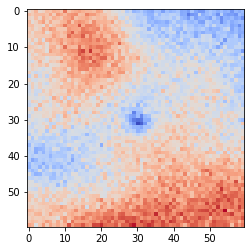

In [51]:
# Choose an object from the catalog
# Choose an object from the catalog
# --------  Try Changing this number to look at different clusters -------- 
n = 128   # <<<<<<<<

ra, dec = [ras[n],decs[n]]
width = 30/60.

# Build the box around the object and cut out a submap from the larger map
box = np.deg2rad([[dec-width/2.,ra-width/2.],[dec+width/2.,ra+width/2.]])

if imap_d56 is not None:
    stamp = imap_d56.submap(box)
else:
    stamp = imap.submap(box)

# Visualize the submap
plt.imshow(stamp, cmap = cm.coolwarm)



## Stacking clusters and using reproject

If we want to stack objects in the map it's relatively easy to do so, but we need to use a slightly different approach. Instead of using a bounding box and cutting a submap from the map we can use pixell's `reproject.thumbnails` function to cut out "stamps" that are reprojected at the center of each object. 

Reprojecting means that we avoid stacking clusters that are distorted due to the rectangular projection of the overall map, as the reprojection will automatically center the "stamp" basis on each individual point source. Users can specify the type of projection using the "proj" keyword. The default is a "gnomonic" projection which projects to a plane that's tangential to the center source so that any distortions are radially symmetric.

Text(0.5, 0, 'Degrees')

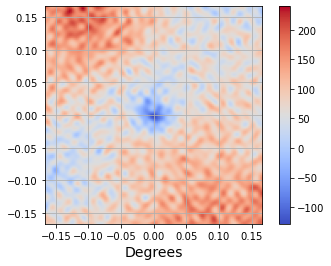

In [52]:
#Reproject the above source and plot - again we need to check if we're using the d56 or the full map 

# Set the size of the stamp:
r_arcmin = 10.  #Define the radius of the image in arcminutes
r = r_arcmin*np.pi/(60 * 180)  # convert arcminutes to radians 

if imap_d56 is not None:
    stamp = reproject.thumbnails(imap_d56, coords = np.deg2rad([decs[n], ras[n]]), res =  0.0000454440, r = r)
else:
    stamp = reproject.thumbnails(imap, coords = np.deg2rad([decs[n], ras[n]]), res =  0.0000454440, r = r)


extent = [-r_arcmin/60., r_arcmin/60., -r_arcmin/60., r_arcmin/60.]
plt.imshow(stamp, extent=extent,cmap = cm.coolwarm)
plt.colorbar()
plt.grid(True)
plt.xlabel("Degrees", fontsize = 14)

We see the utility of `reproject.thumbnails` in action: the source is now centered in the new coordinates! Now we stack all of the reprojected sources.  Note this may take a few minutes to run due to the number of sources !

In [44]:
N = len(ras)
print(N)

100


Text(0.5, 0, 'Degrees')

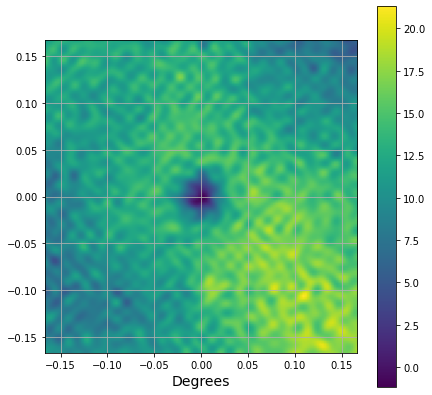

In [53]:
N = 100 #len(ras)
ras=ras[0:100]
decs=decs[0:100]

stack = 0
c = 0 # counter to check how many thumbnails we are stacking

if imap_d56 is not None:
    stamps = reproject.thumbnails(imap_d56, coords=np.deg2rad([decs,ras]).T, res=0.0000454440, r=r)
else:
    stamps = reproject.thumbnails(imap, coords=np.deg2rad([decs,ras]).T, res=0.0000454440, r=r)
stack  = np.mean(stamps,0)

# Plot the Stack
plt.figure(figsize = (7,7))
plt.imshow(stack, extent = extent)
plt.grid(True)
plt.colorbar()
plt.xlabel("Degrees", fontsize = 14)


It looks like the average source in our catalog is a well-defined cold spot relative to the surrounding CMB. This is qualitatively consistent with our understanding of a typical thermal-SZ cluster observed at 150 GHz (see e.g. [Carlstrom et al 2002](https://doi.org/10.1146/annurev.astro.40.060401.093803)). We examine tSZ clusters in  more detail in [Section 6](Section_6_Component_separated_maps.ipynb).

## <font color='blue'> Exercise <font>

The stack above uses the entire catalog but we can also stack in bins according to redshift, mass or whatever other parameters we're interested in. 

If you call `tab.columns` you'll be able to examine some of these different attributes (these attributes are also described in more detail [here](https://heasarc.gsfc.nasa.gov/W3Browse/ground-based/actszclust.html). Try selecting objects from the catalog based on different attributes and creating stacks of point sources that correspond to those attributes.  E.g. stacking on objects by redshift bins or mass bins. 


## Applications: Aperture Photometry and Radial Binning
Stamps are especially useful for additional analysis techniques that rely on the source being centered in the frame. One such technique is Aperture Photometry (AP), which can be used to calculate the brightness of objects. 

This code calculates the average temperature of an aperture: a circle of radius $x$ centered at the origin. It then finds the temperature of a ring of equal area around the circle (outer radius $\sqrt{2}x$), and subtracts the temperature of this ring from the temperature of the aperture.  We repeat this for multiple radii and can then plot the AP result against radii.

This code gives a good introduction to Aperture Photometry, however, there are a few drawbacks.  For example we don't account for distortions in the area of each pixel due to projection effects.  In order to better deal with these effects, and if you're interested in running more complex routines on these stamps we encourage you to consult the package developed by Emmanuel Schaan called [Thumbstack](https://github.com/EmmanuelSchaan/ThumbStack).

In [17]:
def aper_photo(x, radii_map, plot):
    '''calculates the flux-background for a single aperature'''
    zeros = np.zeros(np.shape(radii_map))
    
    circle_sum = np.sum(np.where(radii_map < x, plot, zeros))
    circle_num = np.sum(np.where(radii_map < x, 1, zeros))
    
    ring_sum = np.sum(np.where(radii_map < np.sqrt(2)*x, plot, zeros)) - circle_sum
    ring_num = np.sum(np.where(radii_map < np.sqrt(2)*x, 1, zeros)) - circle_num
    return np.nan_to_num(circle_sum/circle_num - ring_sum/ring_num)

def aper_plot(r, radii, stamp):
    '''Creates the aperature photometry plot for a given stamp'''
    aper_plot = np.zeros(np.shape(r))
    for i in range(np.size(r)):
        aper_plot[i] = aper_photo(r[i], radii, stamp)
    return aper_plot



/var/folders/1b/3hxrghjn3f93mf719bbpxvz40000gn/T/ipykernel_60960/3456859678.py:10: RuntimeWarning:

invalid value encountered in double_scalars



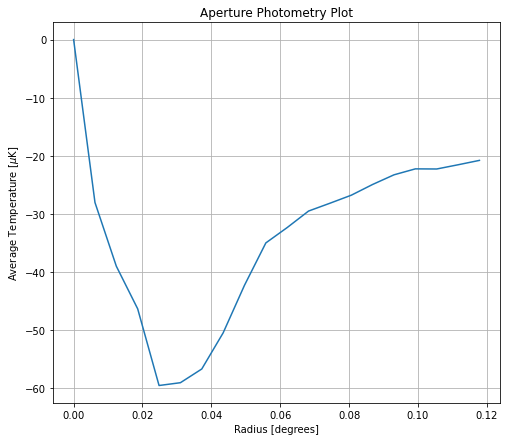

In [18]:
# Call the function modrmap that stores the radii in degrees of each pixel from the center
radii = enmap.modrmap(stamp.shape, stamp.wcs)*180/np.pi

# Determine the bounds for the bins
r_max = np.max(radii)
r_min = np.min(radii)

# define the radii we want for the aperature plot, note the maximum aperature radius is chosen to avoid edge effects
r = np.linspace(r_min, r_max/2, 20)


plt.figure(figsize = (8,7))
plt.title("Aperture Photometry Plot")
plt.xlabel("Radius [degrees]")
plt.ylabel("Average Temperature [$ \mu $K]")
plt.grid(True)
plt.plot(r, aper_plot(r, radii, stamp))
plt.show()

The idea with aperture photometry is that the circle is a guess for the size of the object itself and the ring is the "background". In the plot above, the curve is about zero initially, this is because the outer ring falls entirely within the object, so the background and the circle are close to the same temperature. For greater radii the curve tilts away from zero as the temperature in the two increasingly differ and the ring "ascends" out of the source. Finally, we see the curve flatten off; this indicates that we've fully enclosed the source.

The stamp corresponding to this AP profile is shown below:

Text(0.5, 0, 'Degrees')

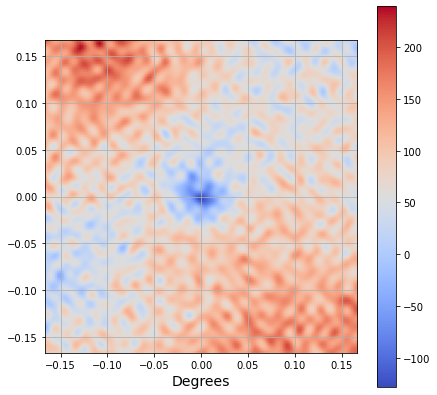

In [19]:
plt.figure(figsize = (7,7))
plt.imshow(stamp, extent=extent,cmap = cm.coolwarm)
plt.colorbar()
plt.grid(True)
plt.xlabel("Degrees", fontsize = 14)



## <font color='blue'> Exercise <font>

Looking at the profile for a single source is always going to give you a reasonably noisy result. Try applying the AP filter technique to the full stack instead of a single point source.
    
You can also approximate some simple error bars for this measurement by looking at the standard deviation in AP profiles for the sources. Since selecting stamps, applying filters, etc is a bit of a slow process you might want to try this for a subset of the data instead of the full data set.
   


## Radial Binning
We will also take a moment to demonstrate how to radially bin a source to look at the profile. 

Below is code that bins data radially, fits the binned data with an exponential curve, and then creates a 2D profile from the fit to approximate the 2D profile of the source. This code can of course be adapted for other uses but here we will look at the stack of clusters, since single sources tend to be less radially symmetric. 

In [20]:
def bin_stamp(data2d, modrmap, bin_edges):
    '''gives the centers and averages for radial bins of a 2d plot'''
    #get centers of each bin
    centers = (bin_edges[1:]+bin_edges[:-1])/2.
    
    #sort indices by corresponding radial bin
    digitized = np.digitize(modrmap.reshape(-1), bin_edges,right=True)

    #get average of each radial bin
    count = np.bincount(digitized)[1:-1]
    res = np.bincount(digitized,(data2d).reshape(-1))[1:-1]/count
    return centers,res



In [21]:
# Define the fit function
def func(x, A, B, C):
    return A*np.exp(B*x) + C

# Set the number of bins
N_bins = 50

# r_edge is the radius of the largest circle that can fit entirely within the box
r_edge = r_max/np.sqrt(2)

step = (r_edge - r_min)/N_bins

# Create the bin edges
bin_edges = np.arange(r_min, r_edge, step)

# Use the binner function to get the average temp for each radius
cents, res = bin_stamp(stack, radii, bin_edges)



In [22]:
# Fit the results from the binner with the exponential
popt, pcov = curve_fit(func, cents, res, p0 = [-1, -1, 80])
res_fit = func(cents, popt[0], popt[1], popt[2])



[Text(0.5, 0, 'Radius [degrees]'),
 Text(0, 0.5, 'Temperature [$ \\mu $K]'),
 Text(0.5, 1.0, 'Residuals')]

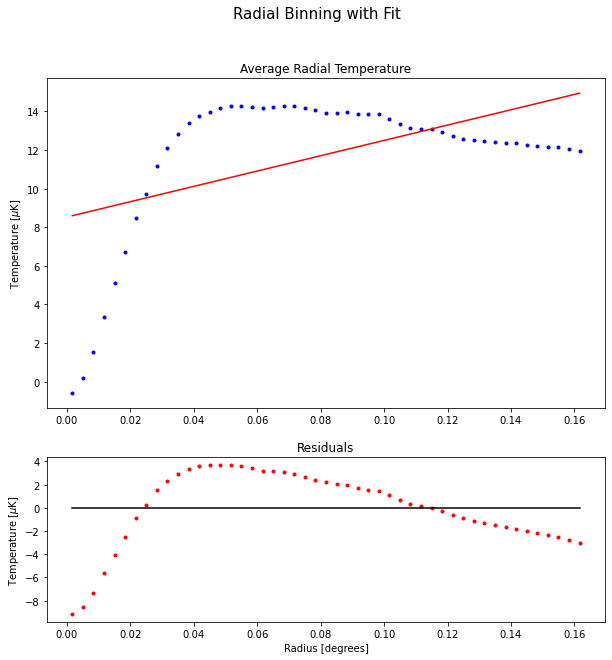

In [23]:
# Plot the radial temp curve and its fit
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10), gridspec_kw={'height_ratios': [2, 1]})
fig.figsize = (10, 9)
fig.suptitle('Radial Binning with Fit', fontsize = 15)

ax1.plot(cents, res, 'b.')
ax1.plot(cents, res_fit, 'r')
ax1.set(ylabel = r"Temperature [$ \mu $K]", title = "Average Radial Temperature")
ax2.plot(cents, res - res_fit, 'r.')

ax2.plot(cents, np.zeros(np.size(cents)), 'k')
ax2.set(xlabel = "Radius [degrees]",
        ylabel = r"Temperature [$ \mu $K]", title = "Residuals")



As shown in the plot above the radial binning curve is nearly exponential, with relatively small residuals. This code uses a fit instead of the raw binning data to "smooth" the values a bit, and so that data can be extrapolated past r-edge (where the corners of the stamp would create errors in the radial binning).  As is evident in the plots above the point sources can't be fit perfectly with this curve, feel free to try other fits by adjusting the function in the previous cells!

## <font color='blue'> Exercise <font>
    
Here we've looked at the radial profile of an average SZ cluster in the CMB maps but we could do the same thing for the radial profile of an average cluster of a specific mass or at a specific redshift. 
    
Try recreating the plots above but for the stacks you created in the first exercise where you stacked in redshift/mass/something else bins. How does the radial profile vary with the parameter you chose to look at?
    

In [ ]:
# Use the radial temp fit to get a 2d map
res_fit_2D = interp1d(cents,res_fit,kind='linear',fill_value='extrapolate')(radii)

# Plot the 2d fit map and the original stack with the fit subtracted
print("Radially binned 2d map")
plt.imshow(res_fit_2D,extent=extent,cmap = cm.coolwarm)
plt.colorbar()
plt.grid(True)
plt.xlabel("Degrees", fontsize = 14)
plt.show()

print("Stack with radial binning subtracted")
plt.imshow(stack - res_fit_2D,extent=extent,cmap = cm.coolwarm)
plt.colorbar()
plt.grid(True)
plt.xlabel("Degrees", fontsize = 14)
plt.show()



In the plot above we can see that the stack is slightly asymetric, this is most likely due to random variation which the stack is not large enough to average out, or due to the inadequacy of the exponential model.  It's also worth noting we've adjusted the scale above in order to make the residuals visible.

## Plot Messier objects

While users are free to search for objects in the maps using catalogs we've also provided a tool to plot random Messier objects from our maps below.  You can enter the Messier number of an object you'd like to look at or feel free to let the function generate an object at random.

In [24]:
def plot_messier(M = None):
    # M should be an integer 

    # read in a table of messier objects that overlap with our feild of view
    tbl = ascii.read(path + "messier_objs.csv", encoding = "utf-8-sig")

    # Check if user has given an object to look for
    if M != None:
        M = str('M') + str(M)
        A = list(tbl['M'])
        if M in A:
            obj = tbl[A.index(M)]
        else:
            print("Sorry that object isn't visible in this map")

    # If no object is given select a random one
    if M == None:
        obj = tbl[random.randrange(0, len(tbl))] 

    # Get the RA and DEC of the object
    ra = coord.Angle(obj["RA"], unit=u.hour) 
    dec = coord.Angle(obj["Declination"], unit = u.degree) 
    
    r = 20.*np.pi/(60 * 180)
    
    # Get a plot of the object
    if imap_d56 is not None:
        stamp = reproject.thumbnails(imap_d56 , coords = [dec.rad, ra.rad], r=r, res =  0.0000454440)
    else:
        stamp = reproject.thumbnails(imap , coords = [dec.rad, ra.rad],  r=r,res =  0.0000454440)
    
    if np.sum(stamp) == 0:
        print("This object wasn't in the D56 full resolution map so we'll switch to a downgraded view.")
        print("Note this may mean it's difficult to see this particular object, consider looking at it with the full depth map instead!")
        stamp = reproject.thumbnails(imap_dg , coords = [dec.rad, ra.rad],  r=r,res =  0.0000454440)
        

    # Establish name for the object, if the common name is given use that, if not 
    # we just use the NGC and M indentifiers
    if type(obj["Common Name"] ) == np.str_:
        name = str(obj["Common Name"])  + str(' NGC: ') + str(obj["NGC"]) + \
        str(' ') + str(obj["M"])
    else:
        name = str('NGC: ') + str(obj["NGC"])+ str(' ') + str(obj["M"])

    # Plot the object 
    plt.imshow((stamp))
    plt.title(name)
    plt.show()

    return 

This object wasn't in the D56 full resolution map so we'll switch to a downgraded view.
Note this may mean it's difficult to see this particular object, consider looking at it with the full depth map instead!


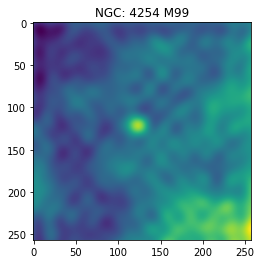

In [38]:
# Try this a few times - some of the objects may be clearer than others
plot_messier()



### Continue to the next section

[Section 5](ACTNotebook_Section_5_Lensing_maps.ipynb):  Introduction to the Lensing maps.